Programmatically generating training datasets
---
**[Link to Github source code](https://github.com/Elucidation/tensorflow_chessbot)**

Previously I built the training data by manually taking several screenshots of the starter board on lichess using different themes, and upscaling/downscaling the screen view in chrome. Then using `tensorflow_chessbot.py` to split up these images into tiles with the known starter configuration for labels. This is not covering the space very well. With that data we built a basic model that is around 98% accurate for a few lichess boards in the starter configuration. 

Though the tiles shouldn't care where on the board they are, it may introduce image artifacts that could confuse the final neural network. To solve this, we need to generate training data in several configurations.

Ideally we'd like to generate our own FEN, and get an actual website board screenshot from it. Since a FEN provides the piece locations, we have our labels and our real data. We can use our same computer vision algorithm to split up the screenshots into tiles which will be fed into our neural network as training data.

In [110]:
# Imports
import numpy as np
import PIL
import os
from IPython.display import Image, display
import helper_webkit2png # Contains screenshot helpers and our wrapper ChessScreenshotServer
helper_webkit2png = reload(helper_webkit2png)
import tensorflow_chessbot # For generating tilesets from chessboard screenshots

# reload(helper_webkit2png.webkit2png)
# reload(tensorflow_chessbot)

# Load chess screenshot server (wrapper for qt gui)
chessServer = helper_webkit2png.ChessScreenshotServer()

QApplication has already been instantiated.
Ignoring given arguments and returning existing QApplication.


---
## Generating random FENs

FEN stands for [Forsyth-Edwards Notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation), which is a dead simple way of encoding a single board layout. It's a string containing 8 sections divided by a `/` corresponding to descending files, and each section contains a character signifying the piece on that rank's square. A number signifies the number of empty spaces between pieces, so say `5p1Q` means 5 spaces, a black pawn, 1 space, and a white queen along that file.

Since there are 12 pieces and a space, and there are 64 squares, to enumerate all possible FEN strings (a subset of which is legal chessboard layouts, but not a requirement here) we'd need $12^{64}=1168422057627266461843148138873451659428421700563161428957815831003136$ strings, roughly `1e69` configurations, so that's not an option.

Another way to look at it is to ignore the overall board layout, each tile only needs to have the piece on it once.

There are some smart things we could do to try and get an optimal distribution of pieces near the edge, near other pieces, etc., but we can also just take a reasonable large random sampling of the configuration space and gain a majority of the useful information needed. Since we're training based on tiles and not overall board layout (for another day), the chessboard doesn't need to have a valid layout.

In [108]:
def getRandomFEN():
    fen_chars = list('1KQRBNPkqrbnp')
    pieces = np.random.choice(fen_chars, 64)
    fen = '/'.join([''.join(pieces[i*8:(i+1)*8]) for i in range(8)])
    # can append ' w' or ' b' for white/black to play, defaults to white
    return fen

fen = getRandomFEN()
print fen + ' w KQkq - 0 1'
print fen.replace('/','-')

prk1Bpnq/nQPpRbQP/qPnp1Q11/qBn1KPNN/rB1RqrPq/R1RrRPBq/NRQQQBbK/bqqPkbk1 w KQkq - 0 1
tiles_chess__prk1Bpnq-nQPpRbQP-qPnp1Q11-qBn1KPNN-rB1RqrPq-R1RrRPBq-NRQQQBbK-bqqPkbk1


---
## Generating screenshots of the FEN
This seemingly daunting task is actually not too bad thanks to the help of several others.  One way is to programmatically load a url and get a render is to use [`pythonwebkit2png`](https://github.com/adamn/python-webkit2png). 

In our case we will use several websites eventually, but this notebook shows just [lichess](https://lichess.org). Lichess provides a RESTful protocol `https://lichess.org/editor/<FEN-STRING>` which loads a page with the board in the FEN configuration.

In [47]:
# Set up URL and output image filename for this run
url = "http://en.lichess.org/editor/%s" % getRandomFEN()
output_filename = "testA.png"

status = chessServer.takeScreenshot(url,output_filename)
if status == 0:
    print "Success"
else:
    print "Failed on %s -> %s" % (url, output_filename)

	Saved screenshot to 'testA.png'
Success


Great! Let's see what it looks like

 FEN: http://en.lichess.org/editor/KRQ1nbrP/BNKbbpbR/PBNpQnRB/n11QbPBb/pKknrpPn/K1BBbqkq/NRrBKNqn/pk1RKN1R


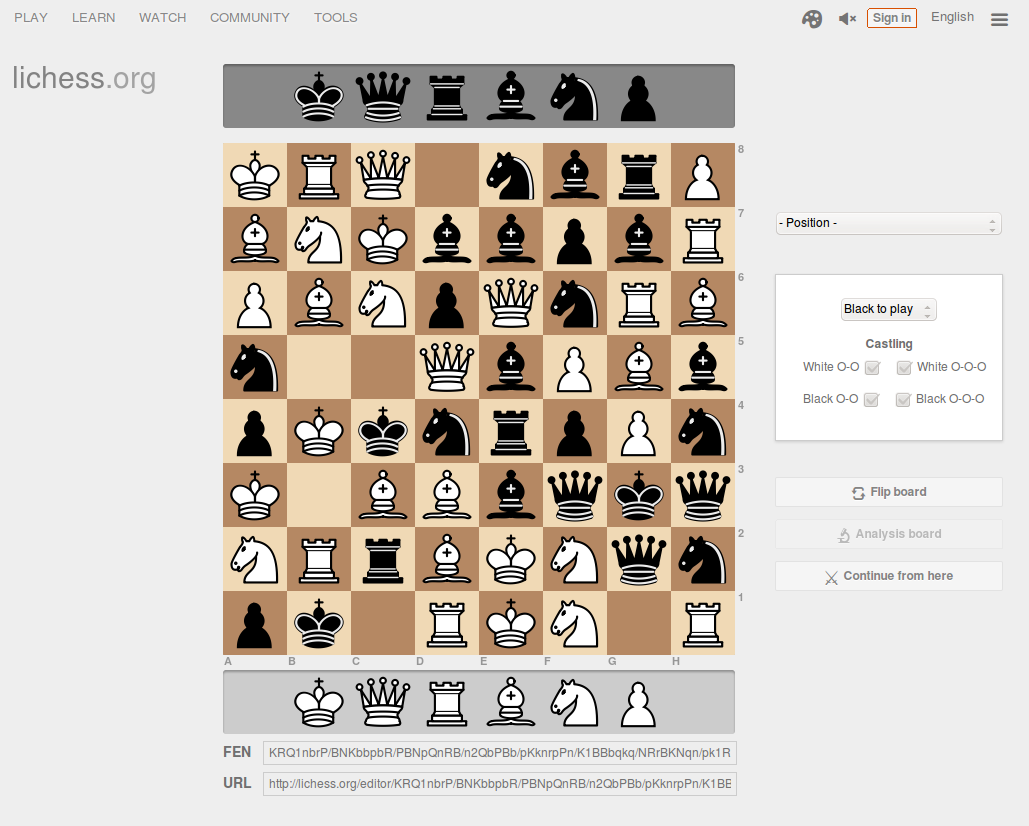

In [49]:
print "FEN:",url
display(Image("testA.png"))

Awesome! Since every render will have the same layout we can crop the picture after the fact to hold just the board.

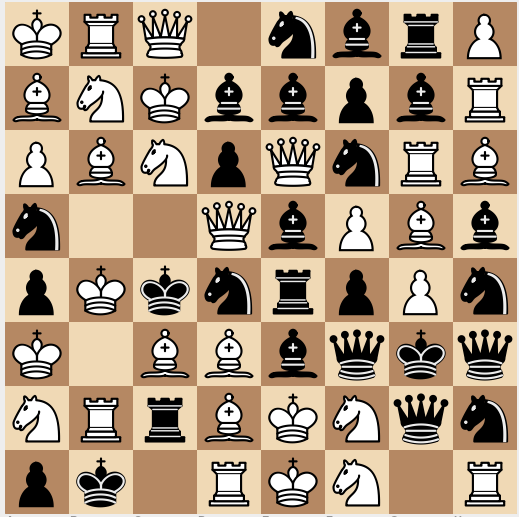

In [50]:
# Crop boundaries
# 218,141
# 737,658
im = PIL.Image.open("testA.png")
im = im.crop([218,141,737,658])
im.save("testA_crop.png")
display(Image("testA_crop.png"))

Looks good, now that we can get tight fit images, let's generate a set of images with the FEN encoded in the filename, this will make it easy to generate training data and labels in one go with the computer vision script. This will create a ton of duplicate tiles, since technically there should only be 26 different tiles with all else being equal. However, this sets the stage for loading different themes for board and pieces. It also allows for training for some image boundary bleed-over when tiles are on the edges of the board. Finally, we'll be able to use this for some other sites like chess.com and PGN viewers, etc.

In [51]:
# Number of random screenshots to generate
N = 1

out_folder = 'train_gen_lichess'
if not os.path.exists(out_folder):
    os.makeoutput_tile_folders(out_folder)

output_filenameA = "testA.png"
output_filenameB = "testB.png"
output_filenames = [output_filenameA, output_filenameB]
for i in range(N):
    # Generate random FEN
    fen = getRandomFEN()
    
    print "#%d : %s" % (i,fen)
    output_filename = "%s/lichess%04d__%s.png" % (out_folder, i, fen.replace('/','-'))
    
    # Render webpage and save screenshot
    status = chessServer.takeChessScreenshot(fen,output_filename)
    
    if status == 0:
        print "\t...Success"
    else:
        print "\tFailed on %s -> %s" % (fen, output_filename)
        break
    
    # Load image, crop and overwrite file
    im = PIL.Image.open(output_filename).crop([218,141,737,658]).save(output_filename)

#0 : PKrQqrrN/nqBqnppb/RqpP1bkr/QnB1kqQn/QqRPRK1k/BQnQpRrp/bkqNbrnq/q1qqrbpr
	Saved screenshot to 'train_gen_lichess/lichess0000__PKrQqrrN-nqBqnppb-RqpP1bkr-QnB1kqQn-QqRPRK1k-BQnQpRrp-bkqNbrnq-q1qqrbpr.png'
	...Success


---
## Themes and Graphic Sets

In addition to loading a screenshot of a random board configuration, there are several themes and sets that change the graphics.

Several themes are available:

```py
["blue", "blue2", "blue3", "canvas", "wood", "wood2", "wood3", "maple", "green", "marble", "brown", "leather", "grey", "metal", "olive", "purple", "Black-White-Aluminium", "Brushed-Aluminium", "China-Blue", "China-Green", "China-Grey", "China-Scarlet", "Classic-Blue", "Gold-Silver", "Light-Wood", "Power-Coated", "Rosewood", "Marble", "Wax", "Jade", "Woodi"]
```

Which I got by running the following javascript (minus leading slash) in a console on the lichess site:

```javascript
\$('.theme').map(function(x) { return $(this).attr('data-theme');})
```

And piece graphic sets:

```
["cburnett", "merida", "alpha", "pirouetti", "chessnut", "chess7", "reillycraig", "companion", "fantasy", "spatial", "shapes", "Basic", "Wood", "Metal", "RedVBlue", "ModernJade", "ModernWood", "Glass", "Trimmed", "Experimental"]
```

using

```javascript
\$('.no-square').map(function(x) { return $(this).attr('data-set');})
```

There's also 3 backgrounds

```py
["light", "dark", "transp"]
```
which I just identified manually with the chrome inspection tool.

In [52]:
themes = ["blue", "blue2", "blue3", "canvas", "wood", "wood2", "wood3", "maple", "green", "marble", "brown", "leather", "grey", "metal", "olive", "purple", "Black-White-Aluminium", "Brushed-Aluminium", "China-Blue", "China-Green", "China-Grey", "China-Scarlet", "Classic-Blue", "Gold-Silver", "Light-Wood", "Power-Coated", "Rosewood", "Marble", "Wax", "Jade", "Woodi"]
pieceSets = ["cburnett", "merida", "alpha", "pirouetti", "chessnut", "chess7", "reillycraig", "companion", "fantasy", "spatial", "shapes", "Basic", "Wood", "Metal", "RedVBlue", "ModernJade", "ModernWood", "Glass", "Trimmed", "Experimental"]
backgrounds = ["light", "dark", "transp"]
print "%d themes, %d sets, %d backgrounds = %d combinations" % (len(themes), len(pieceSets), len(backgrounds), len(themes)*len(pieceSets)*len(backgrounds))

31 themes, 20 sets, 3 backgrounds = 1860 combinations


So there are 1860 combinations of themes and piece sets. Lets say we want 5 random boards per combination, with random pieces on each tile. This comes out to $1860*5*64=595,200$ tiles. That should be a decent amount for training such a simple neural network.

*Note: specifically for lichess screenshots, with some dubious ability to handle random screenshots from other sites*

To take a screenshot with the right theme, we need to pass a cookie with the information included. I went on the lichess site in an incognito window and looked at the cookie it stores:

```
lila2=cf31a05a7b738a4c89d5bddf16dbde0d3c57082d-sid=JSWp1JBD&theme=blue&bg=dark&pieceSet=alpha
```

The session id and previous value is generated whenever you go to the browser, so **you'll probably need to create your own manually** since they expire. It looks like there are 3 keys which contain our theme, background and pieceSet, which we will modify and pass in a cookie.

**NOTE: Unfortunately need unique session tokens, WIP, manually getting cookie, and then autogenerating several random layouts**

In [35]:
# Number of random screenshots to generate
N = 5
out_folder = 'train_images'
if not os.path.exists(out_folder):
    os.makeoutput_tile_folders(out_folder)
#
code = '4eecbbd0982b8d26060c17c3de8f5602ae335290-sid=JSWp1JBD&theme=wood&bg=dark&pieceSet=cburnett'
code = '67193ee101f00274ea7d6bc77143486a3dde571f-sid=JSWp1JBD&theme=wood3&bg=dark&pieceSet=cburnett'
code = 'b7d9a7cae17ff905547e70fb8f6d0a50c12bd374-sid=JSWp1JBD&theme=leather&bg=dark&pieceSet=cburnett'
code = 'f7a1bab2c73cdf316f8bf5dc1d8edc251acc0f2f-sid=JSWp1JBD&theme=canvas&bg=dark&pieceSet=cburnett'
code = 'cf31a05a7b738a4c89d5bddf16dbde0d3c57082d-sid=JSWp1JBD&theme=blue&bg=dark&pieceSet=alpha'
code = '07c1a977da8b8eae5678a79e79e210cbd4580010-sid=JSWp1JBD&theme=wood&bg=dark&pieceSet=alpha'
code = 'f7fb62b208d088c9adc20482f68bff20d622ffc4-sid=JSWp1JBD&theme=leather&bg=dark&pieceSet=alpha'
code = 'ca778a1d8b8680824d6501f68e6db721351fea0a-sid=JSWp1JBD&theme=wood3&bg=dark&pieceSet=alpha'
code = 'a526bbcc9c4e1e00889474b70b53101f4087a0eb-sid=JSWp1JBD&theme=canvas&bg=dark&pieceSet=merida'
code = 'fc8d4d2042dcea51baee213c62eae8405fc9bcee-sid=JSWp1JBD&theme=canvas&bg=dark&pieceSet=pirouetti'
code = 'b257e599862eeb99bcbed10c2aeaa784d25e345d-sid=JSWp1JBD&theme=canvas&bg=dark&pieceSet=chessnut'
code = 'a6b8c83fd2f311060dbad47693d344758f6f5e24-sid=JSWp1JBD&theme=blue3&bg=dark&pieceSet=chess7'
code = 'd5e79b290d1073e0b86978e97c9af6f81d0b0e9e-sid=JSWp1JBD&theme=blue3&bg=dark&pieceSet=reillycraig'
code = '85f4f0f8f80804683c8ddd719e6c9dd9ffb697e9-sid=JSWp1JBD&theme=blue3&bg=dark&pieceSet=merida'
code = '21cc203f3087b359862644ee20cc549420d9549d-sid=JSWp1JBD&theme=blue3&bg=dark&pieceSet=cburnett'
code = '4c333906715a33b5d48908f44603508b8c767a10-sid=JSWp1JBD&theme=blue3&bg=dark&pieceSet=alpha'
for i in range(N):
    # Generate random FEN
    fen = getRandomFEN()
    
    print "#%d : %s" % (i,fen)
    output_filename = "%s/lichess%04d__%s.png" % (out_folder, i, fen.replace('/','-'))
    
    # Render webpage and save screenshot
    # Unfortunately have to generate cookie manually
    theme,bg,pieceSet = themes[2],"dark",pieceSets[0]
    
    cookie = 'lila2=%s'%code
    
    status = chessServer.takeChessScreenshot(fen,output_filename,cookie)
    
    if status == 0:
        print "\t...Success"
    else:
        print "\tFailed on %s -> %s" % (fen, output_filename)
        break
    
    # Load image, crop and overwrite file
    im = PIL.Image.open(output_filename).crop([218,141,737,658]).save(output_filename)

#0 : qNBRrPKp/brRRqbQp/1prrRbRk/bknPkbqn/QrnpNPpb/QbQkKQnk/Rqr1NrbB/rnkkkBbR
	Saved screenshot to 'train_images/lichess0000__qNBRrPKp-brRRqbQp-1prrRbRk-bknPkbqn-QrnpNPpb-QbQkKQnk-Rqr1NrbB-rnkkkBbR.png'
	...Success
#1 : kQRBKkNb/qRKNbkk1/kRPPqKKP/BbBQnBkb/qbqRKPQN/RpBNqNQn/rq1nkqrk/KrrqBNN1
	Saved screenshot to 'train_images/lichess0001__kQRBKkNb-qRKNbkk1-kRPPqKKP-BbBQnBkb-qbqRKPQN-RpBNqNQn-rq1nkqrk-KrrqBNN1.png'
	...Success
#2 : bRnnRbKN/Bbbk1Q1R/QpbQPqrb/PRRNqPBQ/QKB1rRpr/r1Pq1qrb/nnppqb1P/1nnRBPrk
	Saved screenshot to 'train_images/lichess0002__bRnnRbKN-Bbbk1Q1R-QpbQPqrb-PRRNqPBQ-QKB1rRpr-r1Pq1qrb-nnppqb1P-1nnRBPrk.png'
	...Success
#3 : p1kPNrkP/knqn1BRn/p1bRQnnr/1qnrp1BQ/rRPQbQkN/qQQ1bpKB/kkrPbbrP/RNBRbKnk
	Saved screenshot to 'train_images/lichess0003__p1kPNrkP-knqn1BRn-p1bRQnnr-1qnrp1BQ-rRPQbQkN-qQQ1bpKB-kkrPbbrP-RNBRbKnk.png'
	...Success
#4 : BrbrKqqR/1NqBbQRn/NNpQNNKP/RK1P1PqB/1kBQ1nKn/NBnn1bBb/kkkkqNrb/KrKQRQn1
	Saved screenshot to 'train_images/lichess0004__BrbrKqqR-1NqBbQRn-N

# Generating from FEN diagram generators
We can create images directly from online FEN chess diagram generators, much quicker. Let's add a couple of those.

http://www.jinchess.com/chessboard/?p=rnbqkbnrpppppppp----------P----------------R----PP-PPPPPRNBQKBNR

http://www.apronus.com/chess/stilldiagram.php?d=DRNBQKBNRPP_PPPPP__P______P___________p_____k____pppQp_pprnbq_bnr0


In [101]:
import urllib, cStringIO
def generateRandomBoards(n, outfolder, img_url_template, fen_chars='1KQRBNPkqrbnp'):
    """Given chess diagram template url, generate n random FEN diagrams from url and save images to outfolder"""
    # http://www.jinchess.com/chessboard/?p=rnbqkbnrpppppppp----------P----------------R----PP-PPPPPRNBQKBNR
    # http://www.apronus.com/chess/stilldiagram.php?d=DRNBQKBNRPP_PPPPP__P______P___________p_____k____pppQp_pprnbq_bnr0
    # No / separators for either choice
    
    # Create output folder as needed
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    
    for i in range(n):
        fen_chars = list(fen_chars)
        fen_arr = np.random.choice(fen_chars, 64)
        fen = ''.join(fen_arr)
        img_url = img_url_template % fen
        img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(img_url).read()))
        if 'apronus' in img_url_template:
            # need to flip FEN file order since the are 1-8 vs 8-1 of normal FEN.
            fen_arr = np.hstack(np.split(fen_arr,8)[::-1])
        
        # Replace - or _ with 1 to be consistent with actual FEN notation
        fen_arr[fen_arr == fen_chars[0]] = '1'
        
        # Add - between sets of 8 to be consistent with saved file format (later converted to / again for analysis link)
        fen = '-'.join(map(''.join, np.split(fen_arr, 8)))
        
        img.save(os.path.join(outfolder, fen+'.png'))
#
generateRandomBoards(20,'chessboards/train_images', "http://www.jinchess.com/chessboard/?p=%s", '-KQRBNPkqrbnp')
generateRandomBoards(20,'chessboards/train_images', "http://www.apronus.com/chess/stilldiagram.php?d=_%s", '_KQRBNPkqrbnp')

---
## Generate Tile images from screenshots
Great, now that we have several boards, let's generate the tiles for them.

In [109]:
# Directory structure
input_chessboard_folder = 'chessboards/train_images'
output_tile_folder = 'tiles/train_tiles_C'

tensorflow_chessbot.generateTileset(input_chessboard_folder, output_tile_folder)

#  1/151 : chessboards/train_images/lichess0000__kpp1QBpR-RpbPQkQn-nQbBrBQk-K1bPNpRP-qbkQppbP-rPbRBnNK-Ppr1rpKP-pRBbnkKK.png
	Skipping existing
#  2/151 : chessboards/train_images/b1KpkNQk-qRrBrPnb-KqqRqRqK-qPPRnnkr-nqrKqpNR-bnpkNRk1-nBnbkqkq-Qk1kN1pq.png
	Skipping existing
#  3/151 : chessboards/train_images/NKNkkbBp-PBBbKNKn-rr1NPbNp-BRpRknbq-qnbPRRrK-NPRnrbRP-BK1QNBrn-PqkkpkBb.png
	Skipping existing
#  4/151 : chessboards/train_images/1qpqQRRb-1NPR1pBn-nQNnknRp-kBQQB1bK-pQNr1Qb1-qKq1RrbN-KknQBPPp-BqpkNKpk.png
	Skipping existing
#  5/151 : chessboards/train_images/lichess0002__1qbq11BB-111BPrRr-bnnPrk1k-bNQ1BprK-NbbbQkpn-nnbqNPkQ-1NPQ1NBr-1nQKrrpP.png
	Skipping existing
#  6/151 : chessboards/train_images/lichess0004__BrbrKqqR-1NqBbQRn-NNpQNNKP-RK1P1PqB-1kBQ1nKn-NBnn1bBb-kkkkqNrb-KrKQRQn1.png
	Skipping existing
#  7/151 : chessboards/train_images/lichess0004__pRrKRQqq-1BQRBrQB-PBNQkBbP-pprQQbqB-1qbKRbqB-NbnRNKRr-QrQnQBNq-rBQBkPbb.png
	Skipping existing
#  8/151 : chessboards/train_im

Alright, with 150 boards, we have 9600 tiles with the format `<FEN>_<RANK><FILE>.png`

For example `PkqrBBKq-RKbRpN1q-rKQRpPNN-PQNNPqBQ-Pqr1bbbp-pRbqnbBn-P1qbQQRr-rpBqRQNk_B6.png`

This gives us all the information we need to load a tile and determine it's label within an image.